In [1]:
"""Simplest Capsule Implementation Based on my understanding of the Paper: https://arxiv.org/abs/1710.09829

With Dynamic Loop.

Referred to clear Doubts: https://github.com/naturomics/CapsNet-Tensorflow
Tried to comment as much as possible, let me know if you find any error.
Test acc: 99.38% # First round with default params of paper
"""
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# 0. Training flags:
train_round = 1
ckpt = '../checkpoints/capsnet_dynamic.ckpt'  # Checkpoint file
resume = True  # True if you have the above file
do_test_first = True  # do test eval
save_after = 430  # and validate # checkpointing global step

batch_size = 128
epochs = 1

In [3]:
# 1. Optional: safe max
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.93

In [4]:
# 2. Optional: reproduce
np.random.seed(100)
tf.set_random_seed(100)

# 3. Data: temporary
mnist = input_data.read_data_sets('/tmp/data/', one_hot=True, reshape=False)
input_size = 28

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


# Hyperparameters

In [5]:
# 4. Architecture parameters: hardcoded as in paper
pc_units = 32
pc_dims = 8
pc_capsules = pc_units * 6 * 6 # right now hard-coded

dc_units = 10
dc_dims = 16
epsilon = 1e-8

# to output activities of local feature detectors
conv_0_params = {'filters': 256, 'kernel_size': 9, 'strides': 1, 
                 'padding': 'valid', 'activation': tf.nn.relu
                }


# to output primary capsules
conv_pc_params = {'filters': pc_units * pc_dims, 'kernel_size': 9, 'strides': 2, 
                  'padding': 'valid', 'activation': tf.nn.relu # <-------- doubt/ works well with relu/ in paper not mentioned
                 }

# arch params
arch_params = {'inp_dims': input_size,
               'pc_dims': pc_dims,
               'out_dims': dc_dims,
               'classes': dc_units,
               'm_plus': 0.9,
               'm_minus': 0.1,
               'lambda_val': 0.5,  # down weight of the loss for absent digit classes # <------------
               'epsilon': epsilon,
               'recon_loss_w': 0.0005, # reconstruction loss weight # <------------
               'num_iters': 3,
               'lr':1e-3,
              }


# New Functions

In [6]:
# 5. Activation function: squash
def squash(in_tensor, axis=-1, name='squash'):
    """Squashing Function: Squash magnitude along an axis but preserve orientation"""
    with tf.name_scope(name):
        norm_square = tf.reduce_sum(tf.square(in_tensor), axis=axis, keep_dims=True, name='norm_square')  # [N, 1, J, 1, 1] if axis = -2
        squash_factor = norm_square / (1 + norm_square) # scalar factor to squash magnitudes b/w 0-1
        orientation = in_tensor / tf.sqrt(norm_square + epsilon) # unchanged
        out_tensor = squash_factor * orientation
        return out_tensor

In [7]:
# 6. Agreement
def prediction_agreement(next_layer_out_predictions, next_layer_outs, name='agree_by_dot'):
    """Agreement: Explain away this layer values, 
       by agreeing predictions of this layer for next layer outputs with next layers real outputs."""
    with tf.name_scope(name): 
        
        # Tile next_layer_outs for each i from I=1152, as we have to see that from 1152 capsules which agree max.
        next_layer_outs = tf.tile(next_layer_outs, multiples=[1, 1152, 1, 1, 1])  # [N, 1152, 10, 16, 1]
        
        # [N, 1152, 10, 1, 16] x [N, 1152, 10, 16, 1] = [N, 1152, 10, 1, 1]
        agreement = tf.matmul(next_layer_out_predictions, next_layer_outs, transpose_a=True)
        
        return agreement

In [8]:
# 7. Route to DC
def routing(capsule_outs, num_iters=3):
    """Routing: Learn routing weights and route, dynamic connection between two capsule layers."""
    
    batch_size = tf.shape(capsule_outs)[0] # will know only during run
    
    with tf.name_scope('predict_next_layer_outs'):
        
        # Tensor containg all transformation matrices W_ij
        W_IJ = tf.Variable(tf.random_normal([1, pc_capsules, dc_units, pc_dims, dc_dims], stddev=0.01))  # [1, 1152, 10, 8, 16]
        W_IJ = tf.tile(W_IJ, multiples=[batch_size, 1, 1, 1, 1])  # [N, 1152, 10, 8, 16] <-- IJ[8, 16]

        # Predict Next Layer's Output
        next_layer_out_predictions = tf.matmul(W_IJ, capsule_outs, transpose_a=True)
    
    with tf.name_scope('routing'):
        # [N, 1152, 10, 1, 1] Constant Value Tensor
        prior_IJ = tf.zeros([batch_size, pc_capsules, dc_units, 1, 1], dtype=np.float32, name='routing_prior')

        def execute(prior_IJ, next_layer_out_predictions, next_layer_outs, counter):
            
            c_IJ = tf.nn.softmax(prior_IJ, dim=2) # [N, 1152, 10, 1, 1]
            next_layer_outs = tf.reduce_sum((c_IJ * next_layer_out_predictions), axis=1, keep_dims=True)  # [N, 1, 10, 16, 1]
            next_layer_outs = squash(next_layer_outs, axis=-2)
            routing_weights = tf.add(prior_IJ, prediction_agreement(next_layer_out_predictions, next_layer_outs))
            return routing_weights, next_layer_out_predictions, next_layer_outs, tf.add(counter, 1)
        
        def check(prior_IJ, next_layer_out_predictions, next_layer_outs, counter):
            return tf.less(counter, 3)
        
        counter = tf.constant(1)
        # dummy Constant Value Tensor to hold digit caps outputs
        next_layer_outs = tf.zeros([batch_size, 1, dc_units, dc_dims, 1], dtype=np.float32, name='dc_out') # [N, 1, 10, 16, 1]
        _, _, next_layer_outs, counter = tf.while_loop(check, execute, [prior_IJ, next_layer_out_predictions, next_layer_outs, counter])
        
        return next_layer_outs # [N, 1, 10, 16, 1]

# Network

In [9]:
class CapsNet:
    def __init__(self, conv_0_params, conv_pc_params, inp_dims=28, pc_dims=8, out_dims=16, classes=10, num_iters=3,
                 recon_loss_w=0.0005, epsilon=1e-9, m_plus=0.9, m_minus=0.1, lambda_val=0.5, lr=1e-3, scope='CapsNet'):

        print('Learning Rate={}, m_plus={}, m_minus={}, lambda_val={}'.format(lr,
                                                                              m_plus,
                                                                              m_minus,
                                                                              lambda_val))

        with tf.variable_scope(scope):
            self.X = tf.placeholder(tf.float32,
                                    shape=[None, inp_dims, inp_dims, 1],
                                    name='inputs')
            self.Y = tf.placeholder(tf.float32,
                                    shape=[None, classes],
                                    name='one_hot_labels')

            self.is_training = tf.placeholder_with_default(True, shape=[], name='bool_for_masking')

            # Get feature maps for basic features
            with tf.variable_scope('conv_0_layer'):
                self.conv_0 = tf.layers.conv2d(self.X, **conv_0_params)  # [N, 20, 20, 256]

            # Get Primary Capsules
            with tf.variable_scope('conv_pc_layer'):

                # raw caps
                self.conv_pc = tf.layers.conv2d(self.conv_0, **conv_pc_params)   # [N, 6, 6, 256]
                batch_size = tf.shape(self.conv_pc)[0]
                self.conv_pc = tf.reshape(self.conv_pc, shape=[batch_size, -1, pc_dims])  # [N, 1152, 8]

                # activated caps
                self.pcaps = squash(self.conv_pc) # squash 1152 capsules along axis=-1
                self.pcaps = tf.reshape(self.pcaps, shape=[batch_size, -1, 1, pc_dims, 1])

            with tf.variable_scope('digit_caps'):

                # tile pcaps activations w.r.t each unit in digit caps
                self.tiled_pcaps = tf.tile(self.pcaps, multiples=[1, 1, classes, 1, 1])
                self.digit_caps_out = tf.squeeze(routing(self.tiled_pcaps, num_iters), axis=[1, -1], name='distributed_prediction') # [N, 10, 16]

            # [N, 10, 16] --> [N, 10] length of vectors for actual predictions
            self.pred_lengths = tf.sqrt(tf.reduce_sum(tf.square(self.digit_caps_out) + epsilon, axis=2, keep_dims=False))

            # [N, 10] --> # [N,]
            self.predictions = tf.squeeze(tf.argmax(self.pred_lengths,
                                                    axis=1, output_type=tf.int32, name='predictions'))
            
            self.one_hot_predictions = tf.one_hot(self.predictions, depth=classes, name='one_hot_predictions')

            # [N, 10] * [N, 10] = [N, 10]
            self.m_plus = self.Y * tf.square(tf.maximum(0., m_plus - self.pred_lengths))  # [N, 10]
            self.m_minus = lambda_val * (1 - self.Y) * tf.square(tf.maximum(0., self.pred_lengths - m_minus))  # [N, 10]
            self.margin_loss = tf.reduce_mean(tf.reduce_sum(self.m_plus + self.m_minus, axis=-1), name='margin_loss')

            self.recon_target = tf.cond(self.is_training,
                                        lambda: self.Y, # Train True use Labels
                                        lambda: self.one_hot_predictions,
                                        name='recon_target')

            with tf.variable_scope('masking'): # WAY 2: <---------------------
                self.masked_pred = tf.matmul(self.digit_caps_out, tf.reshape(self.recon_target, shape=[-1, 10, 1]),
                                             transpose_a=True, name='masked_pred')  # [N, 16, 10] x [N, 10, 1] = [N, 16, 1]
            with tf.variable_scope('decoder'):
                # [N, 16, 1] --> [N, 16]
                decoder_inp = tf.reshape(self.masked_pred,
                                         shape=[-1, out_dims])
                self.fc1 = tf.layers.dense(decoder_inp,
                                           units=512,
                                           activation=tf.nn.relu,
                                           name='fc1')
                self.fc2 = tf.layers.dense(self.fc1,
                                           units=1024,
                                           activation=tf.nn.relu,
                                           name='fc2')

                self.pred_X = tf.layers.dense(self.fc2,
                                              units=inp_dims * inp_dims,
                                              activation=tf.nn.sigmoid,
                                              name='pred_X')  # [N, 28*28]

                self.pred_image = tf.reshape(
                    self.pred_X, shape=[-1, inp_dims, inp_dims, 1])

            # Backward
            self.reconstruction_loss = tf.reduce_sum(tf.square(tf.reshape(self.X,
                                                                          shape=[-1, inp_dims * inp_dims]) - self.pred_X),
                                                     name='reconstruction_loss')

            self.loss = tf.add(self.margin_loss, recon_loss_w * self.reconstruction_loss,
                               name='loss')
            self.optimizer = tf.train.AdamOptimizer(learning_rate=lr)
            self.global_step = tf.Variable(0, name='global_step',
                                           trainable=False)
            self.train_op = self.optimizer.minimize(self.loss,
                                                    global_step=self.global_step)

            # function variables/ops:
            # [N, 10] --> # [N,]
            self.true = tf.squeeze(tf.argmax(self.Y, axis=1,
                                             output_type=tf.int32, name='true_values'))

            self.correct = tf.cast(tf.equal(self.true,
                                            self.predictions), dtype=tf.float32)
            self.acc = tf.reduce_mean(self.correct) * 100
            # meta variables:
            self.tvars = tf.trainable_variables()

    def predict(self, xs, ys=None, is_training=True, get_recon_images=False, sess=None):
        """Returns Predicted Number and Reconstructed Image."""
        sess = sess or tf.get_default_session()

        if is_training and ys is None and get_recon_images:
            print("Would need true one hot encoded labels..for masking..")
            return

        if ys is None:
                ys = np.zeros([10, 10], dtype=np.float32) # dummy

        if get_recon_images:
            return sess.run([self.predictions, self.pred_image], feed_dict={self.X: xs,
                                                                            self.Y: ys,
                                                                            self.is_training: is_training})
        else:
            return sess.run(self.predictions, feed_dict={self.X: xs})

    def accuracy(self, xs, ys, sess=None):
        """Predicts and returns accuracy at current state."""
        sess = sess or tf.get_default_session()
        return sess.run(self.acc, feed_dict={self.X: xs, self.Y: ys})

    def learn(self, xs, ys, is_training=True, val_xs=None, val_ys=None, sess=None):
        """Train Step"""
        sess = sess or tf.get_default_session()

        if val_xs is not None and val_ys is not None:
            val_acc = self.accuracy(val_xs, val_ys, sess=sess)
            return val_acc
        else:
            train_acc, loss, _ = sess.run([self.acc, self.loss, self.train_op], feed_dict={
                                          self.X: xs, self.Y: ys, self.is_training: is_training})
            return train_acc, loss


# Train

In [10]:
# Training:
"""
55,000 data points of training data (mnist.train),
10,000 points of test data (mnist.test)
and 5,000 points of validation data (mnist.validation).
"""

test_batch_size = 100

tf.reset_default_graph()

caps_net = CapsNet(conv_0_params, conv_pc_params, **arch_params)
print('Network Built..')

saver = tf.train.Saver(var_list=caps_net.tvars)
file = open('avg_log_{}.csv'.format(train_round), 'w')
file.write('step,avg_train_acc,step_val_acc\n')

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())

    if resume:
        saver.restore(sess, ckpt)
        print('RESUMED..')

    if do_test_first:
        print('TESTING..')
        ta = 0
        total_steps = len(mnist.test.images) // test_batch_size

        for step in range(1, total_steps + 1):
            val_x, val_y = mnist.test.next_batch(test_batch_size)
            test_batch_accuracy = caps_net.accuracy(val_x, val_y, sess)
            ta += test_batch_accuracy
            print('{},{:>3.3f}'.format(step, test_batch_accuracy))

        print('Test Accuracy: ', ta / total_steps)

    print('*' * 90)
    print('Training..learning_rate = {}, total_epochs = {}'.format(arch_params['lr'], epochs))
    total_steps_approx = save_after * epochs
    val_acc_base = 99.38 # Already Trained till this accuracy
    ta = 0
    for step in range(1, total_steps_approx + 1):

        batch_x, batch_y = mnist.train.next_batch(batch_size, shuffle=True)
        global_step = sess.run(caps_net.global_step)

        if step % save_after == 0:
            print('Validation in progress..')
            va = 0
            total_steps = len(mnist.validation.images) // test_batch_size
            for v in range(total_steps):
                val_x, val_y = mnist.validation.next_batch(test_batch_size, shuffle=True)
                val_accuracy = caps_net.accuracy(val_x, val_y, sess)
                va += val_accuracy

            print('Validation log in..avg_log_{}.csv'.format(train_round))
            va = va / total_steps
            file.write('{},{:>3.3f},{:>3.3f}\n'.format(step, ta / save_after,
                                                       va))
            file.flush()
            ta = 0

            if va > val_acc_base:
                saver.save(sess, ckpt)
                print('SAVED..old best val acc = {}, new best val acc = {}'.format(val_acc_base, va))
                val_acc_base = va

        else:
            train_accuracy, train_loss = caps_net.learn(batch_x, batch_y,
                                                        sess=sess)
            print('{},{:>3.3f},{:>3.3f}'.format(step, train_accuracy,
                                                train_loss))
            ta += train_accuracy

file.close()

Learning Rate=0.001, m_plus=0.9, m_minus=0.1, lambda_val=0.5
Network Built..
INFO:tensorflow:Restoring parameters from ../checkpoints/capsnet_dynamic.ckpt
RESUMED..
TESTING..
1,100.000
2,99.000
3,100.000
4,98.000
5,100.000
6,100.000
7,99.000
8,98.000
9,99.000
10,99.000
11,100.000
12,99.000
13,98.000
14,96.000
15,100.000
16,100.000
17,100.000
18,100.000
19,99.000
20,100.000
21,100.000
22,99.000
23,100.000
24,100.000
25,100.000
26,99.000
27,99.000
28,100.000
29,100.000
30,100.000
31,99.000
32,100.000
33,99.000
34,100.000
35,100.000
36,99.000
37,99.000
38,100.000
39,99.000
40,98.000
41,99.000
42,98.000
43,99.000
44,100.000
45,99.000
46,100.000
47,99.000
48,99.000
49,99.000
50,98.000
51,100.000
52,98.000
53,98.000
54,99.000
55,100.000
56,100.000
57,100.000
58,99.000
59,100.000
60,100.000
61,100.000
62,100.000
63,100.000
64,99.000
65,100.000
66,100.000
67,99.000
68,98.000
69,99.000
70,99.000
71,100.000
72,99.000
73,99.000
74,99.000
75,100.000
76,100.000
77,99.000
78,100.000
79,100.000
80,98

386,100.000,0.248
387,100.000,0.235
388,100.000,0.243
389,100.000,0.234
390,100.000,0.209
391,100.000,0.244
392,100.000,0.247
393,100.000,0.238
394,100.000,0.241
395,100.000,0.235
396,100.000,0.254
397,100.000,0.217
398,100.000,0.253
399,100.000,0.242
400,100.000,0.243
401,100.000,0.228
402,100.000,0.267
403,100.000,0.251
404,100.000,0.250
405,100.000,0.239
406,100.000,0.218
407,100.000,0.258
408,100.000,0.250
409,100.000,0.247
410,100.000,0.236
411,100.000,0.245
412,100.000,0.254
413,100.000,0.239
414,100.000,0.237
415,100.000,0.244
416,100.000,0.238
417,100.000,0.251
418,100.000,0.225
419,100.000,0.239
420,100.000,0.256
421,100.000,0.233
422,100.000,0.237
423,100.000,0.220
424,100.000,0.233
425,100.000,0.234
426,100.000,0.240
427,100.000,0.227
428,100.000,0.238
429,100.000,0.242
Validation in progress..
Validation log in..avg_log_1.csv
SAVED..old best val acc = 99.38, new best val acc = 99.4


# VISUAL

In [11]:
n_imgs = 10
random_idxs = np.random.choice(10000, size=n_imgs, replace=False)
imgs = mnist.test.images[random_idxs].reshape([-1, 28, 28, 1])
print(imgs.shape)

(10, 28, 28, 1)


In [12]:
tf.reset_default_graph()

caps_net = CapsNet(conv_0_params, conv_pc_params, **arch_params)
print('Network Built..')

saver = tf.train.Saver(var_list=caps_net.tvars)

with tf.Session() as sess:
    saver.restore(sess, ckpt)
    print("Weights loaded..")
    
    decoder_input, recon_imgs, pred = sess.run([caps_net.masked_pred, caps_net.pred_image, caps_net.predictions],
                                                feed_dict={caps_net.X: imgs,
                                                          caps_net.is_training: False,
                                                          caps_net.Y: np.zeros([10, 10], dtype=np.float32)})
    print("Done..")

Learning Rate=0.001, m_plus=0.9, m_minus=0.1, lambda_val=0.5
Network Built..
INFO:tensorflow:Restoring parameters from ../checkpoints/capsnet_dynamic.ckpt
Weights loaded..
Done..


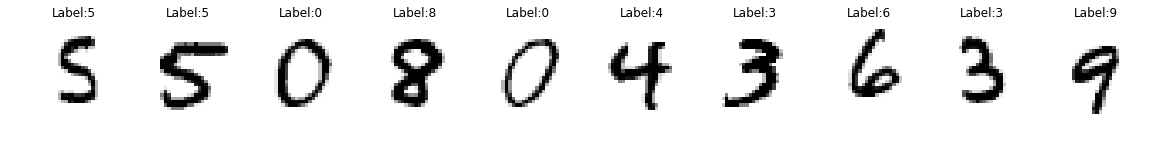

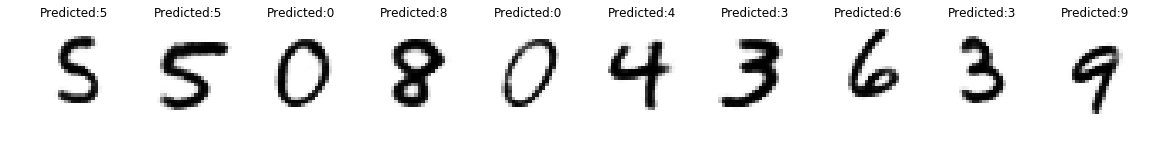

In [13]:
real_imgs = imgs.reshape(-1, 28, 28)
pred_imgs = recon_imgs.reshape([-1, 28, 28])

plt.figure(figsize=(n_imgs * 2, 3))

for idx, ridx in zip(range(n_imgs), random_idxs):
    plt.subplot(1, n_imgs, idx + 1)
    plt.imshow(real_imgs[idx], cmap="binary")
    plt.title("Label:" + str(np.argmax(mnist.test.labels[ridx], axis=0)))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_imgs * 2, 3))

for idx in range(n_imgs):
    plt.subplot(1, n_imgs, idx + 1)
    plt.title("Predicted:" + str(pred[idx]))
    plt.imshow(pred_imgs[idx], cmap="binary")
    plt.axis("off")
    
plt.show()


# What's in the Output of Digit Caps? What Does each dimension represent?

In [14]:
decoder_input = np.squeeze(decoder_input)
decoder_input.shape # 10 sample predictions of 16D

(10, 16)

In [15]:
# (10 * hm, 16)
def get_altered_dcs(vectors, deltas, axis=-1):
    dimensions = vectors.shape[axis]
    dims_idxs = np.arange(dimensions)
    # calculate the updates for each dimension for each vector for each image
    updates = np.zeros(shape=[dimensions, hm, 1, dimensions])
    updates[dims_idxs, :, 0, dims_idxs] = deltas
    # apply update
    new_vectors = vectors.reshape(1, 1, *vectors.shape) + updates
    return new_vectors

In [16]:
hm = 9
minm = -0.6
maxm = 0.6
deltas = np.linspace(minm, maxm, hm)
deltas

array([-0.6 , -0.45, -0.3 , -0.15,  0.  ,  0.15,  0.3 ,  0.45,  0.6 ])

In [17]:
new_vectors = get_altered_dcs(decoder_input, deltas)
new_vectors.shape

(16, 9, 10, 16)

In [18]:
new_vectors = new_vectors.reshape(-1, decoder_input.shape[-1])
new_vectors.shape

(1440, 16)

In [19]:
old_labels = np.argmax(mnist.test.labels[random_idxs], axis=0)
old_labels.shape

(10,)

In [20]:
new_labels = np.tile(old_labels, hm * decoder_input.shape[-1])
new_labels.shape

(1440,)

In [21]:
# Get Output of Decoder network, with tweaked vectors as inputs

with tf.Session() as sess:
    saver.restore(sess, ckpt)
    print("Weights loaded..")
    one_hot_labels = sess.run(tf.one_hot(new_labels, depth=10))
    recon_imgs = sess.run(caps_net.pred_image,
                          feed_dict={caps_net.masked_pred: np.expand_dims(new_vectors, axis=-1),
                                     caps_net.is_training: True, # to mask with new labels
                                     caps_net.Y: one_hot_labels})
    print("Done..")

INFO:tensorflow:Restoring parameters from ../checkpoints/capsnet_dynamic.ckpt
Weights loaded..
Done..


In [22]:
recon_imgs.shape

(1440, 28, 28, 1)

In [23]:
new_imgs = recon_imgs.reshape([dc_dims, hm, n_imgs, input_size, input_size])
new_imgs.shape

(16, 9, 10, 28, 28)

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 0


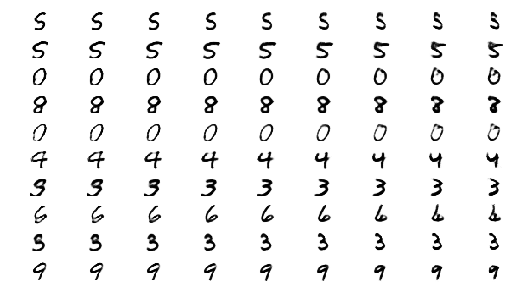

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 1


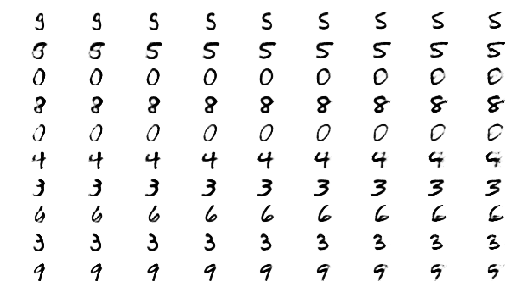

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 2


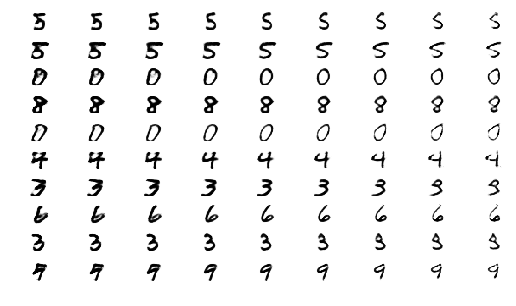

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 3


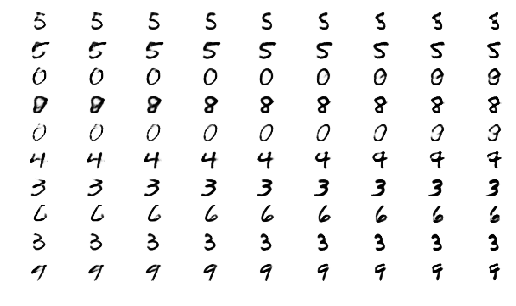

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 4


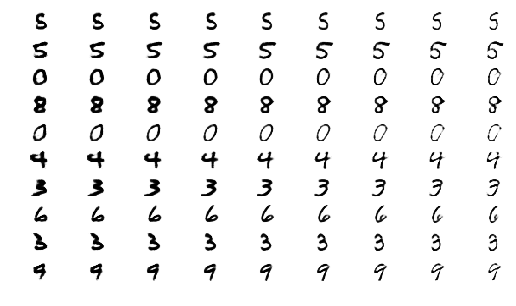

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 5


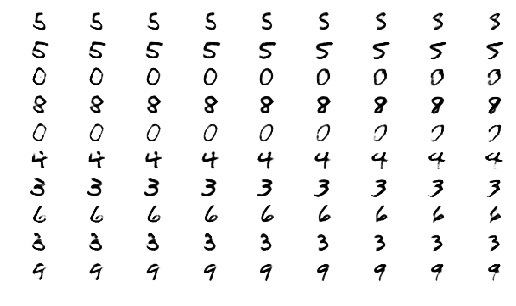

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 6


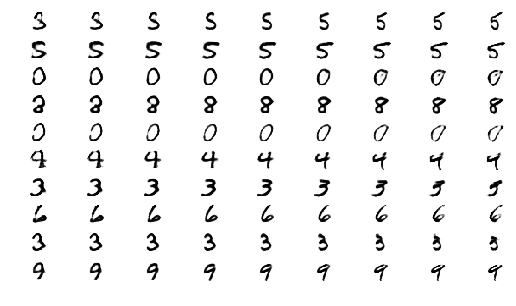

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 7


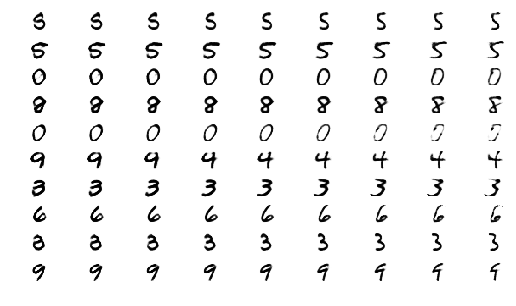

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 8


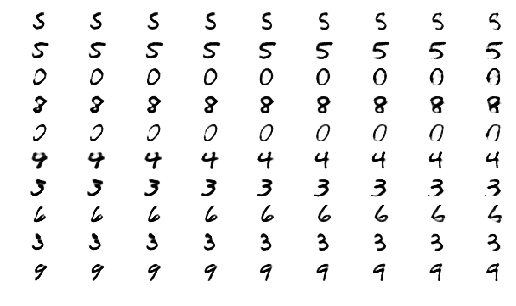

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 9


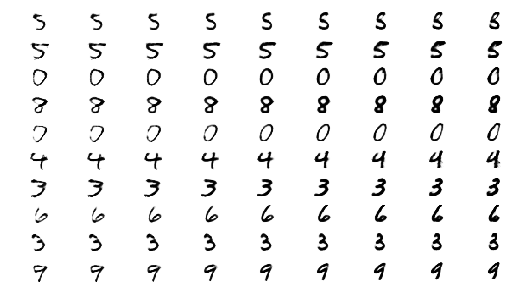

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 10


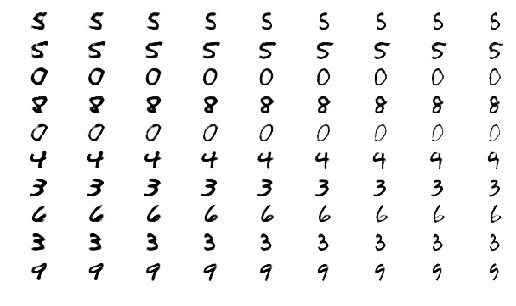

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 11


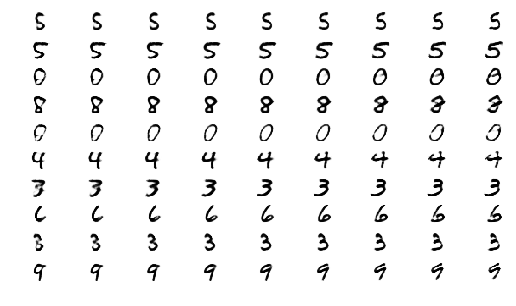

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 12


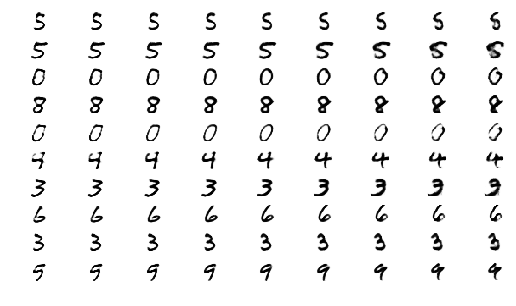

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 13


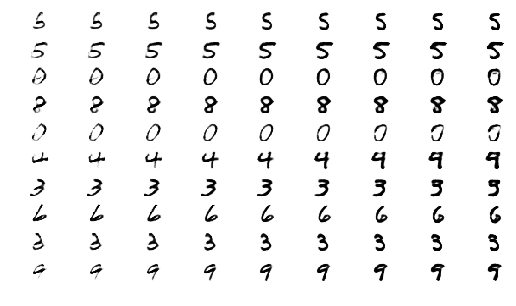

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 14


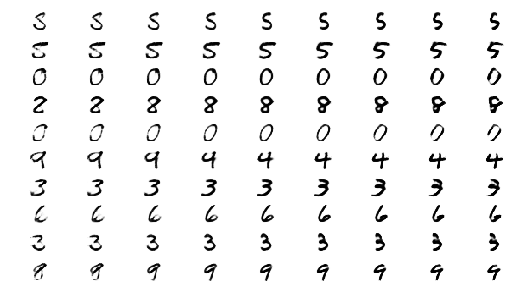

Changes(columns):  [-0.6  -0.45 -0.3  -0.15  0.    0.15  0.3   0.45  0.6 ]
Results for 10 images(rows), for Dimension: 15


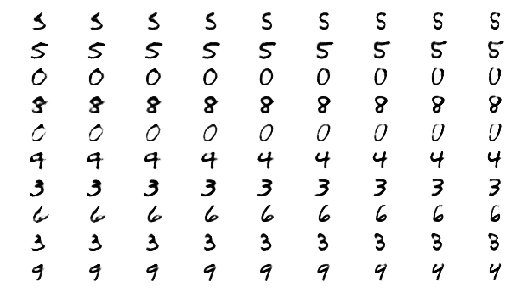

In [24]:
for d in range(dc_dims):
    print('Changes(columns): ', deltas)
    print('Results for {} images(rows), for Dimension: {}'.format(n_imgs, d))
    plt.figure(figsize=[hm, n_imgs / 2])
    for i in range(n_imgs):
        for j in range(hm):
            plt.subplot(n_imgs, hm, i * hm + j + 1)
            plt.imshow(new_imgs[d, j, i], cmap='binary')
            plt.axis('off')
    plt.show()